In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading our data

In [2]:
data = pd.read_excel("data/Ex1_2.xlsx", header=0, 
                     parse_dates=[0], 
                     index_col=0).squeeze("columns")

In [3]:
data.head(10)

Date
2015-01-01    1006.699649
2015-01-02    3197.751826
2015-01-03    3217.491035
2015-01-04    2151.573759
2015-01-05    4243.929892
2015-01-06    3178.012617
2015-01-07    1816.007210
2015-01-08    3020.098947
2015-01-09    3671.492837
2015-01-10    3138.534200
Name: series1, dtype: float64

Let's plot this time series data

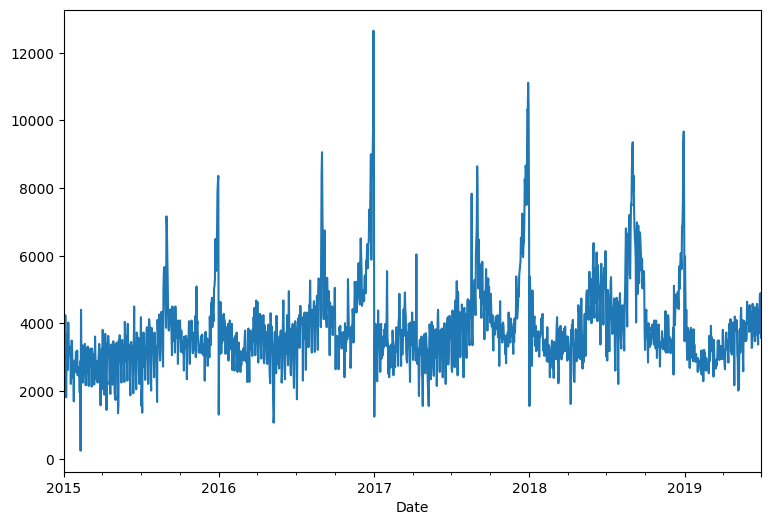

In [4]:
plt.figure(figsize=(9,6))
data.plot();

Plotting with different rolling windows to reduce the noise

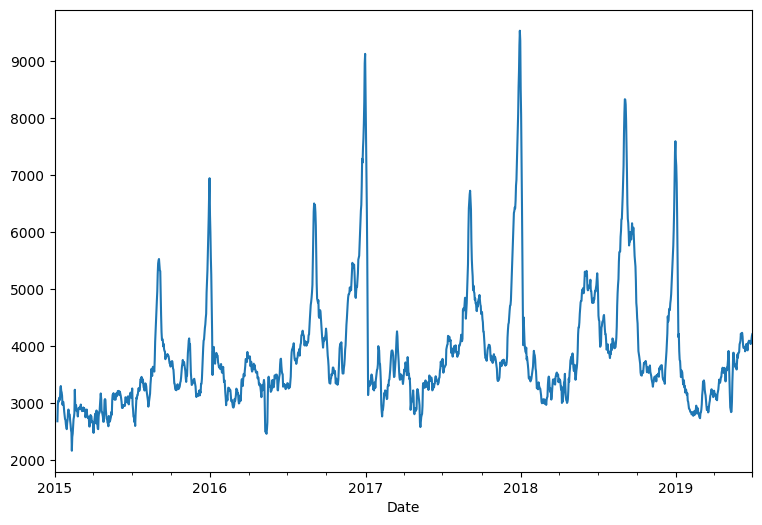

In [5]:
#weekly window
plt.figure(figsize=(9,6))
data.rolling(window=7).mean().plot();

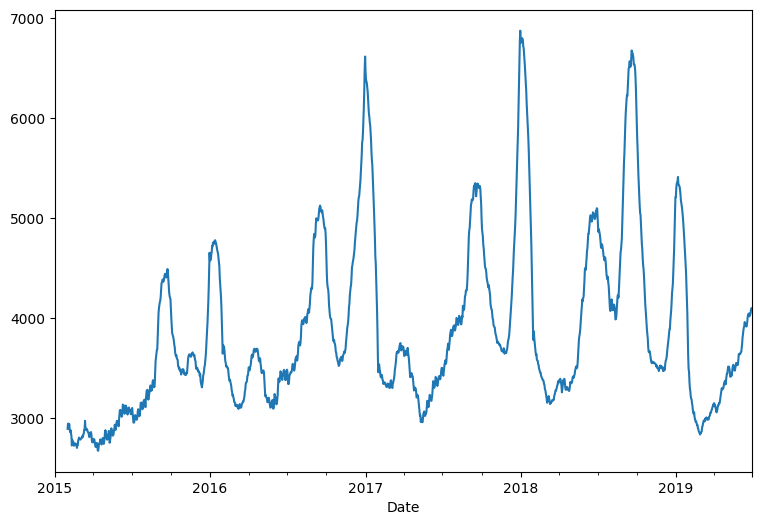

In [6]:
#monthly window
plt.figure(figsize=(9,6))
data.rolling(window=31).mean().plot();

**We can see that data has yearly season trend, with the high splashes on September and in the end of the year.**

Let's plot one year of our data for more closely view.

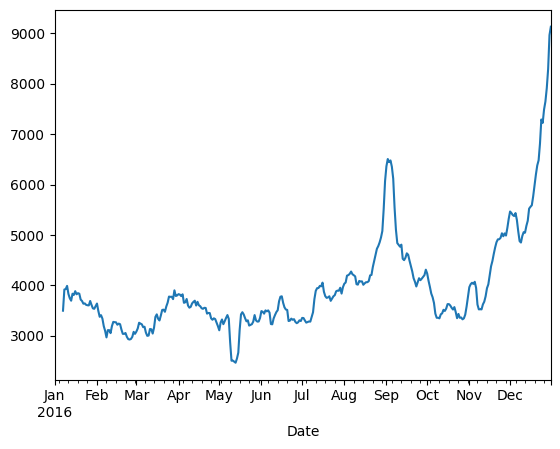

In [7]:
data[data.index.year == 2016].rolling(window=7).mean().plot();

Let's split our data into components (trend, seasonal, residuals)

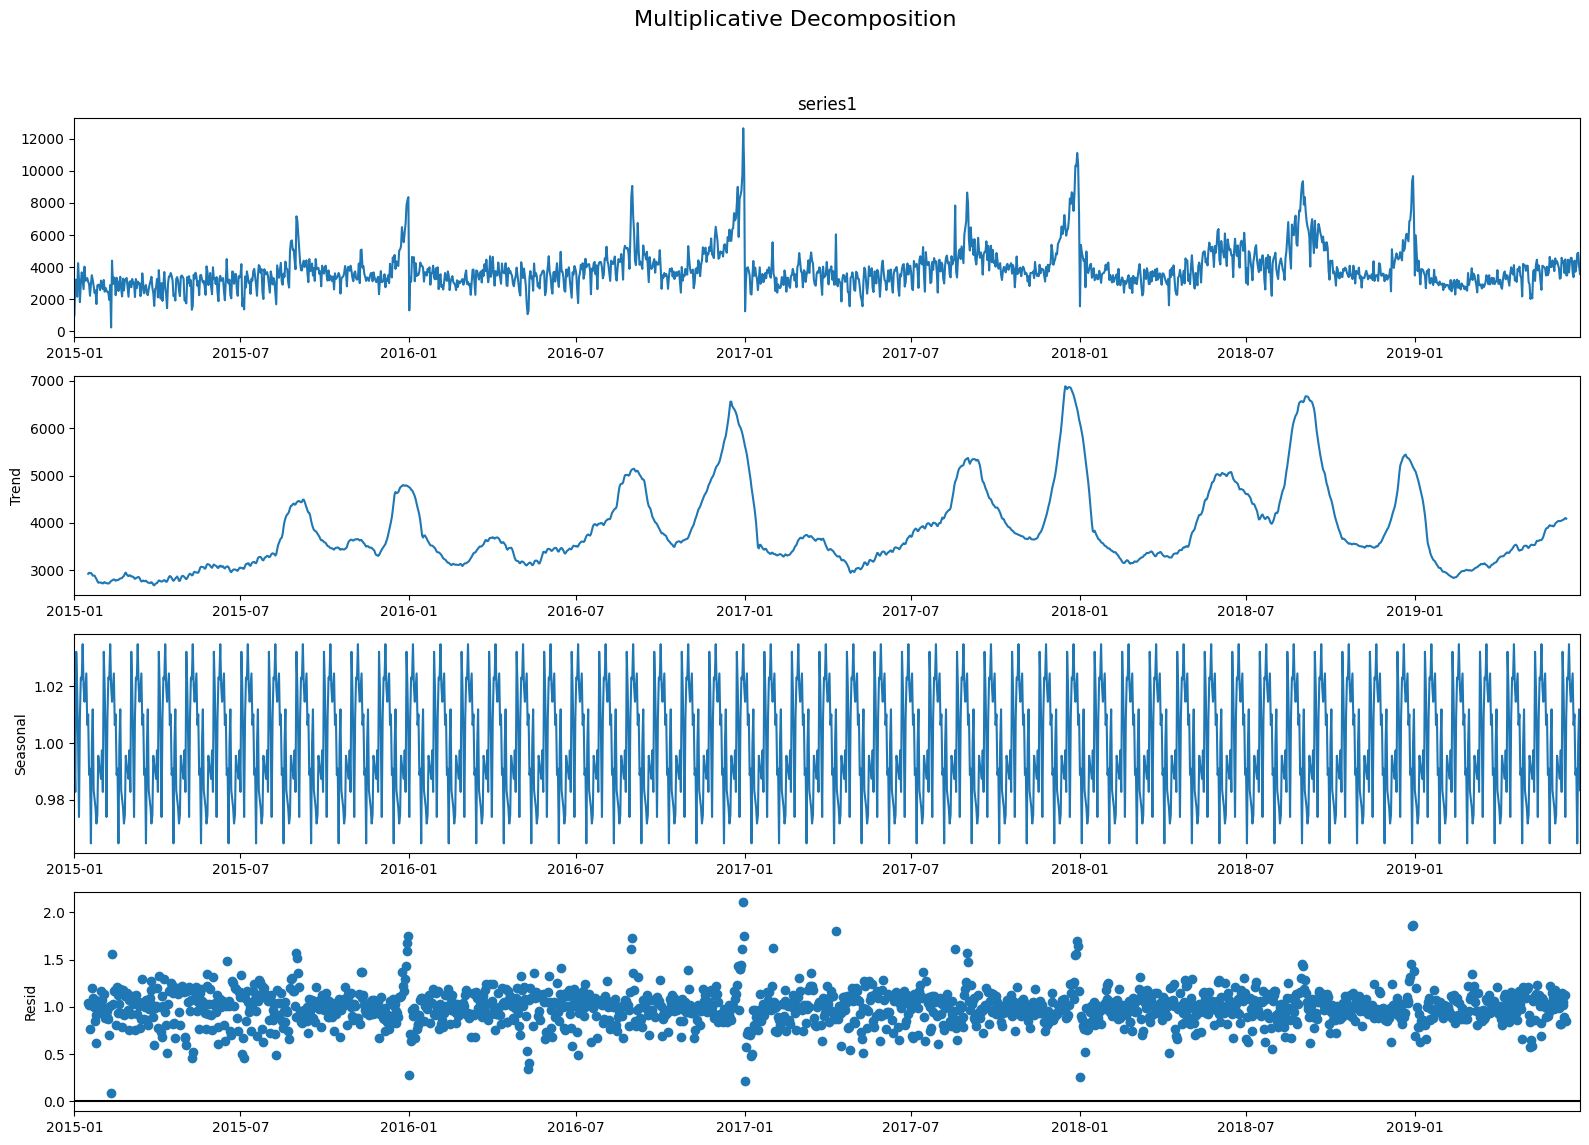

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(data, model='multiplicative', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

By eyes we can see seasonal trending. Let's make some stationarity tests with statsmodels python library. 

### Stationarity tests

In [9]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

Dickey–Fuller test: p=0.000002


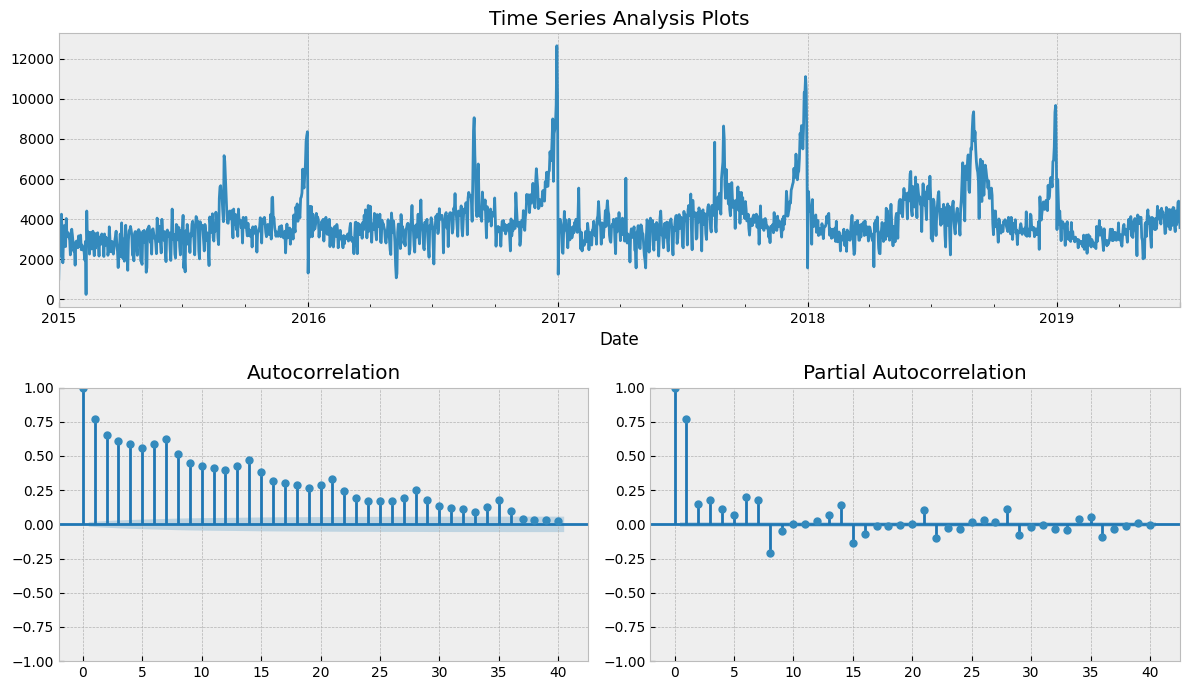

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method="ywm")

        print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(data, lags=40)

**Dickey-Fuller test shows very small p-value, that rejects the Null Hypothesis of non-stationarity. But on ACF chart we can see season trending of our data. Let's resample our data by month and plot again our ACF lags.**

Dickey–Fuller test: p=0.198648


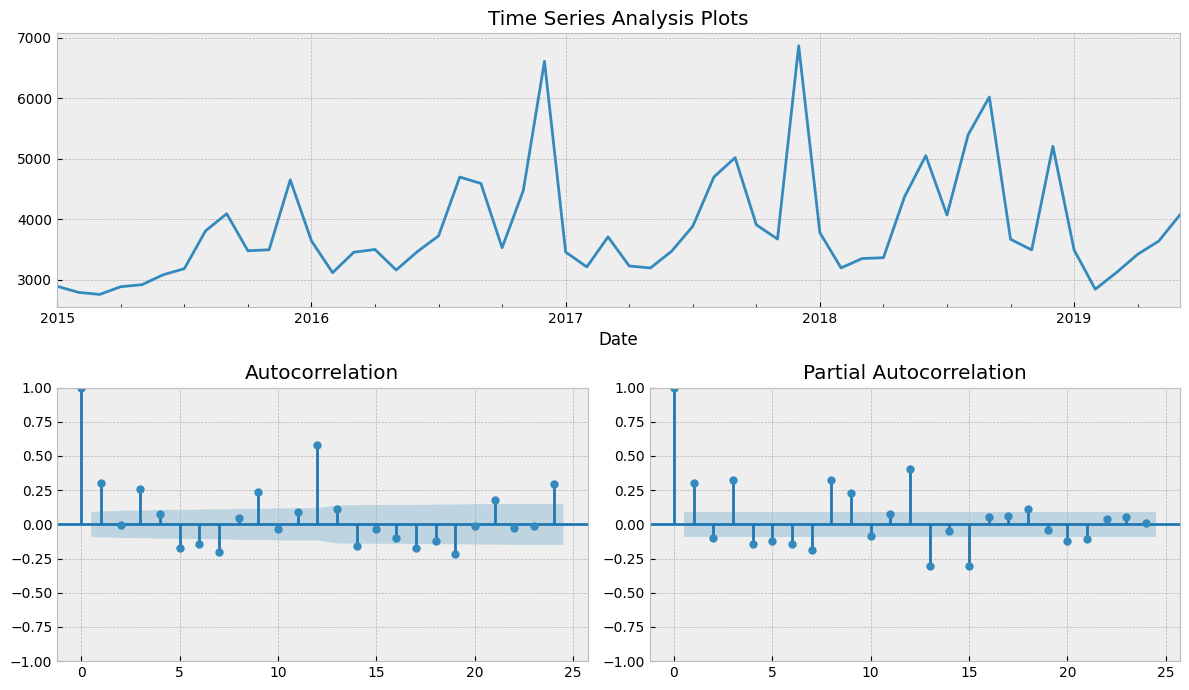

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method="ywm")

        print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(data.resample('M').mean(), lags=24)

We can't reject the null hypothesis of series stationarity. And we can clearly observe significant lags - 1, 3, 9, 12
**In january, march, september and december we have seasonly dependencies**

Let's make a KPSS test to be more sure

In [11]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [13]:
kpss_test(data)

Results of KPSS Test:
Test Statistic            0.807187
p-value                   0.010000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\antil\.virtualenvs\study-VCz3FZhX\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS test has another H0, that series is stationary. And with resulting p-value we can reject it. 

**So, our time series is non-stationary**

### Forecasting

We have a non-stationary time series. We have to predict a daily values in future 3 months. It's will be a huge season component (365). For this task let's use facebook library [**Prophet**](https://facebook.github.io/prophet/). 

It uses additive regression model with four main components: 
- a piecewise linear logistic growth curve trend; 
- a yearly seasonal component modelled using Fourier series;
- a weekly seasonal component created using dummy variables;
- a user-provided list of important holidays.

In [17]:
import logging
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [18]:
#prepare the data
data = pd.read_excel("data/Ex1_2.xlsx", header=0, parse_dates=[0])
data.columns = ["ds", 'y']

In [19]:
m = Prophet()
m.fit(data);
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:31 - cmdstanpy - INFO - Chain [1] done processing


We need to predict 3 months after June. It is a 92 days

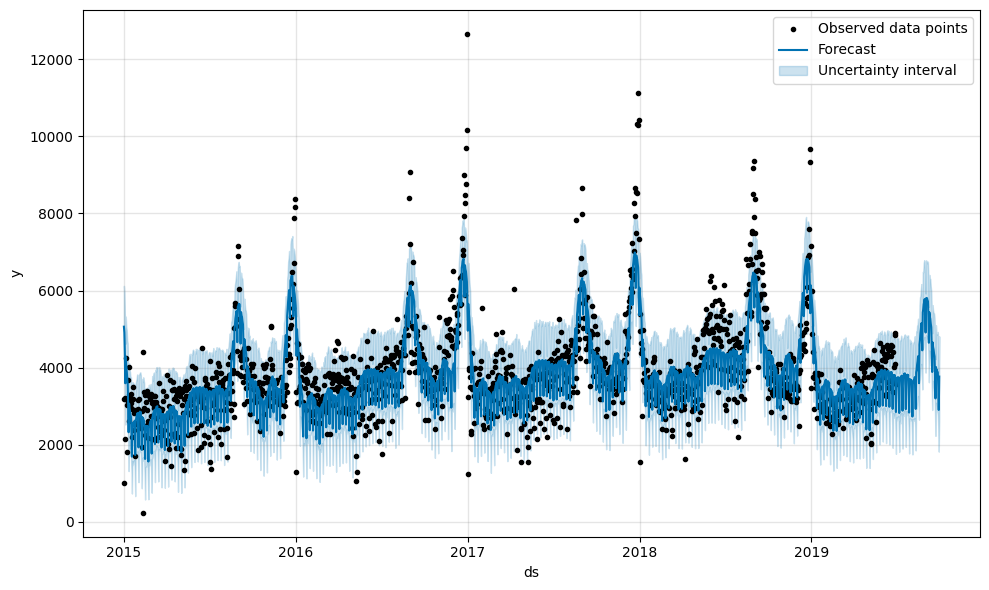

In [20]:
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)
m.plot(forecast, include_legend=True);

Plot the components, that the model found in data

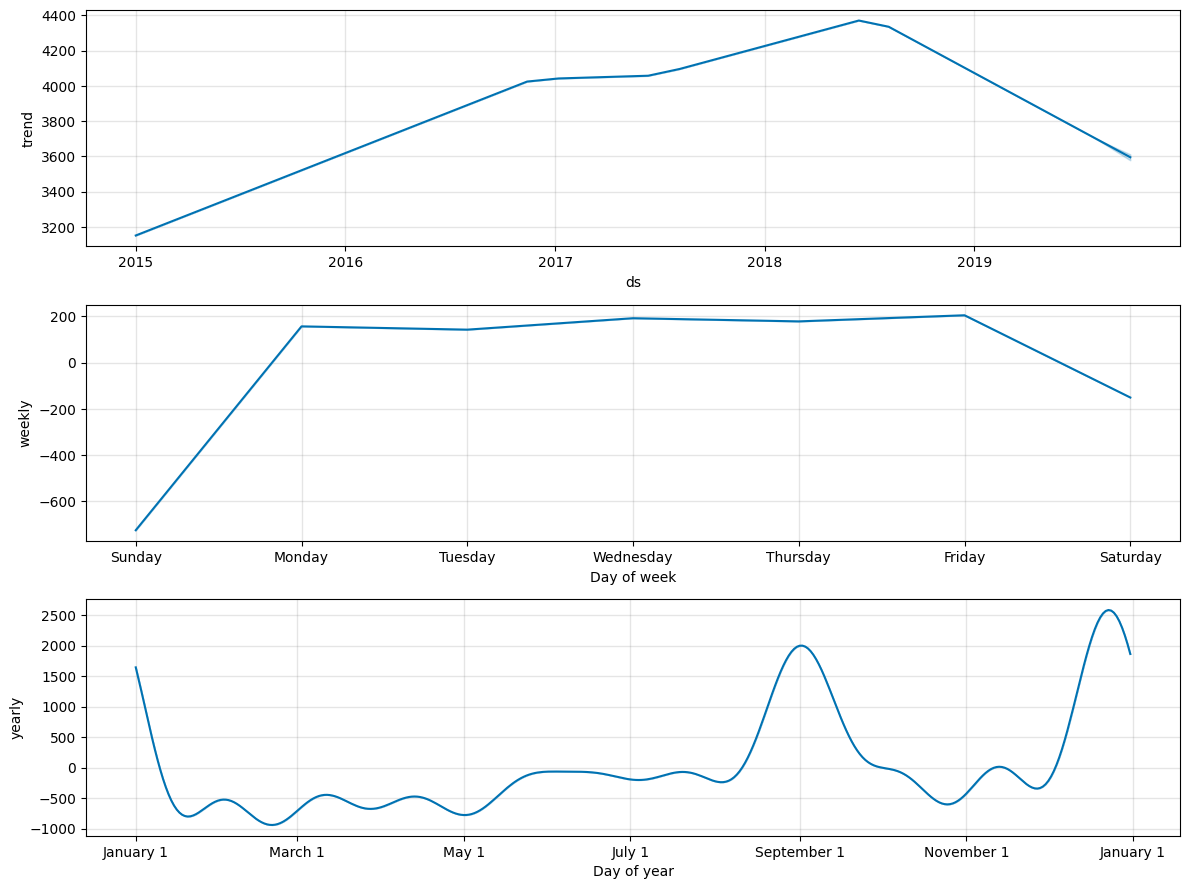

In [26]:
m.plot_components(forecast, figsize=(12,9));

Our model has found some dependencies:

**-Values on weekdays are higher than on weekends**

**-Values on January, September and December also higher than in other months.**

Plot our forecasts and true data on a single chart

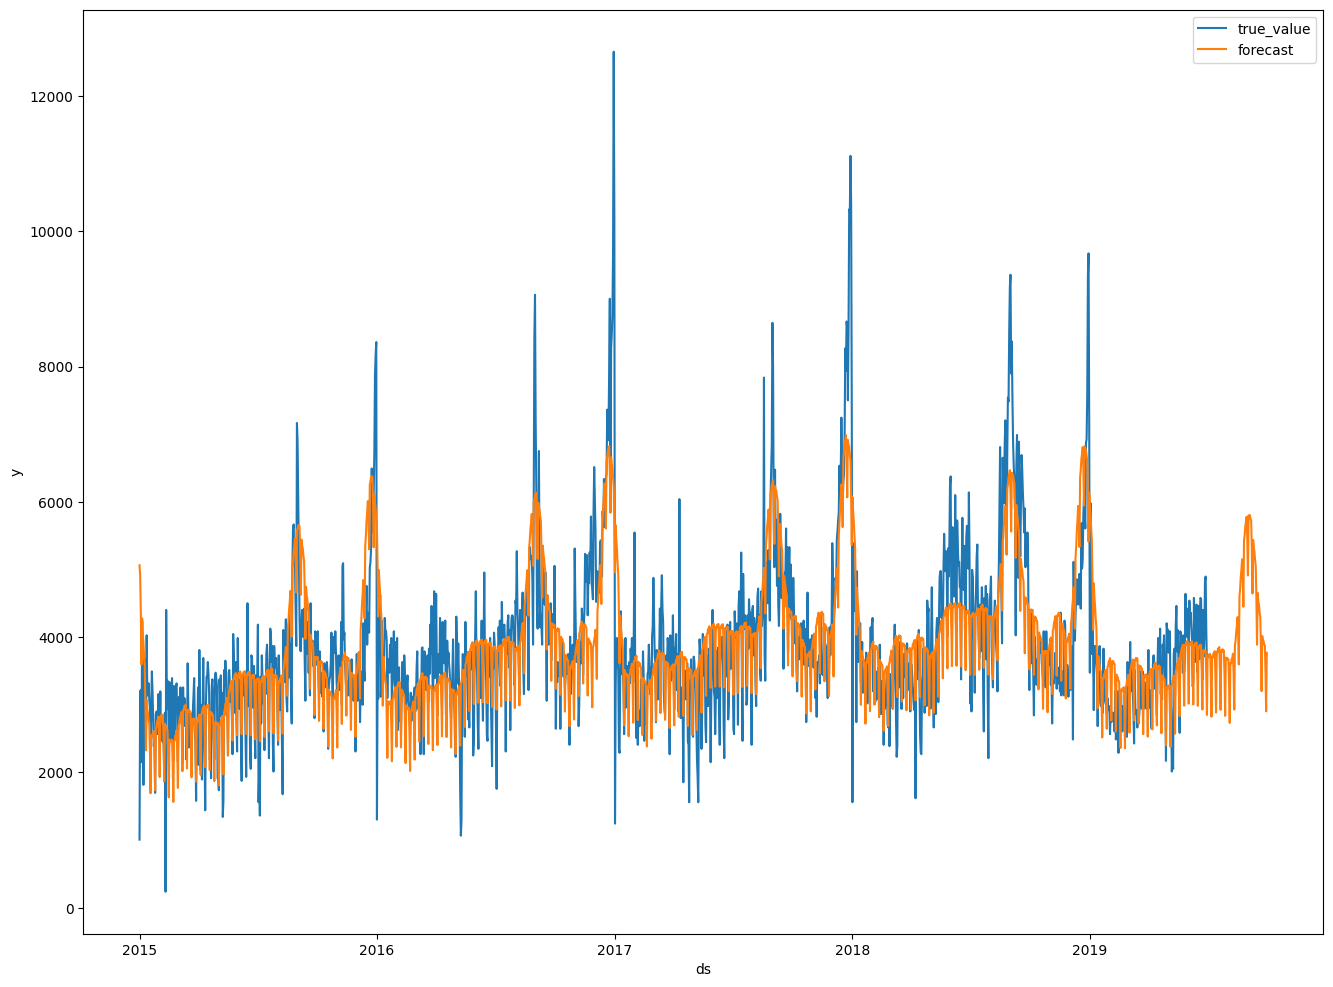

In [29]:
sns.lineplot(data=data, x="ds", y="y", label="true_value")
sns.lineplot(data=forecast, x="ds", y="yhat", label="forecast");

Let's observe just our forecasting

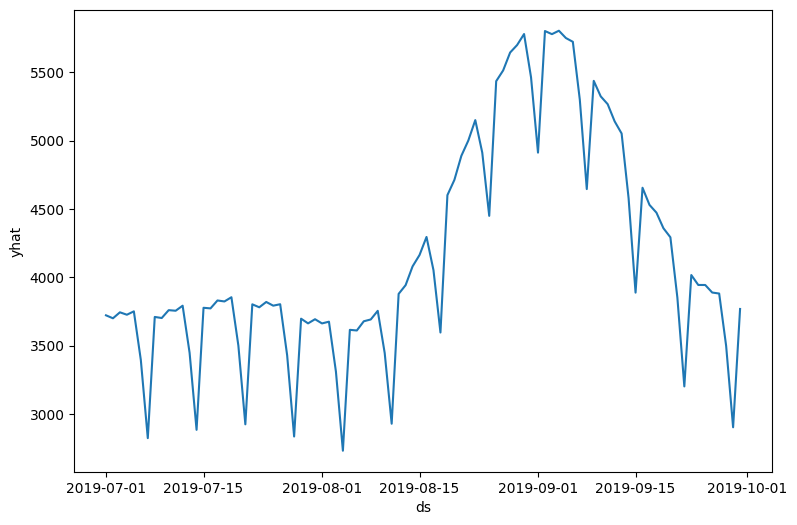

In [30]:
plt.figure(figsize=(9,6))
sns.lineplot(data=forecast[forecast.ds > "2019-06-30"][["ds", "yhat"]], x="ds", y="yhat");

Look's good, it captures the weekly dependencies and the splash in September 

Now, validate our model with **time series cross validation**.


In [31]:
df_cv = cross_validation(m, initial='365.25 days', period='45 days', horizon = '92 days');

  0%|          | 0/27 [00:00<?, ?it/s]

In [36]:
df_cv[["ds", "yhat", "y"]]

,ds,yhat,y
0,2016-01-16,3656.707381,3947.841760
1,2016-01-17,3123.169454,3099.055782
2,2016-01-18,4317.801986,3671.492837
3,2016-01-19,4139.741009,3671.492837
4,2016-01-20,4196.752483,3474.100749
...,...,...,...
2479,2019-06-26,3251.934793,4007.059387
2480,2019-06-27,3225.877047,4836.106157
2481,2019-06-28,3236.904339,4895.323783
2482,2019-06-29,2876.443979,4086.016222


Metrics calculation

In [23]:
df_p = performance_metrics(df_cv)
df_p[['horizon', 'rmse', 'mape']]

,horizon,rmse,mape
0,10 days,892.194818,0.169289
1,11 days,878.936015,0.167429
2,12 days,871.115715,0.169576
3,13 days,854.626493,0.167050
4,14 days,845.256504,0.167766
...,...,...,...
78,88 days,1313.100487,0.235403
79,89 days,1247.263630,0.236090
80,90 days,1203.915822,0.234071
81,91 days,1145.802092,0.221330


Let's display MAPE metric as a function of horizon length

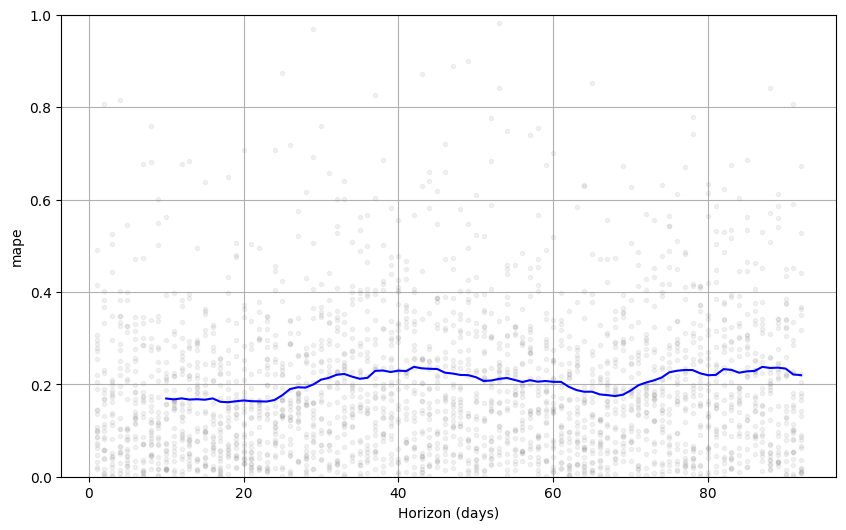

In [24]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim((0,1));

**We have got approximately 20% error in 3 months forecasting. I think it is a eligible result**

In [25]:
#writing predictions vector
forecast[forecast.ds > "2019-06-30"][["ds","yhat"]].set_index("ds").to_csv("task1_predictions.csv")